# Surface Mass Balance: XGB 

Import relevant Libaries 

In [1]:
%pip install pyarrow
%pip install plotly
%pip install feature_engine
%pip update pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "update"
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats

# Visualizations
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns

# Set WD
import os
from pyrsistent import v
os.getcwd()
#os.chdir('/Users/asgerlyngeholst-hansen/Desktop/GEUS-Master-Thesis/')
#os.chdir('C:\\Users\\nifu18ab\\Desktop\\GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/GEUS-Master-Thesis')
os.chdir('/Users/nilsfulde/Desktop/Master_Thesis')

#### Load KM_L 

In [34]:
df = pd.read_csv('data/promice/preprocessed/daily/SCO_L.csv')

##### Pre-processing

In [35]:
#Remove all NA values if training should be done only on ablation
df = df.dropna()

# Remove only values from Wind direction if training should be done on entire dataset
#df = df[df['Wind from direction (upper boom)'].notna()] 

In [37]:
# This bit retrieve the indexes for all melting season categories and remove column from df
for category in ['pre', 'beginning', 'middle', 'end']:
    exec(f"indices_{category} = df[df['Melting Season'] == '{category}'].index")

# This bit retrieve the indexes for Ablation periods
for category in [True]:
    exec(f"indices_ablation = df[df['Ablation'] == {category}].index")

indices_all = df[df['Ablation'].isin([True, False])].index

In [40]:
# This bit to include only relevant features
exclude_list = [                                                    'index', # excluded because of unimportant information
                                                                     'stid', # excluded because of unimportant information
                                                               'Unnamed: 0', # Old Index
                                                                 'Ablation',
                                                           'Melting Season',
                                              'year', 'month','day', 'hour', # Drop because of sin & cos values
                                                                 'subgroup'
               ]

df = df[[column for column in df.columns if column not in exclude_list]]


In [41]:
# This bit to change the datetime variables into a form that a ML models can understand
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html
    
    
# This bit to split Datetime column into year, month, day, hour columns
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Datetime'] = df['Datetime'].dt.strftime('%Y-%m-%d')

df['Datetime'] = pd.to_datetime(df['Datetime'])

#Create new columns
df['year'] = df['Datetime'].dt.year 
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day
#df['hour'] = df['Datetime'].dt.hour

#Drop the datetime column
df.drop(columns=['Datetime'], inplace=True)

In [42]:
# This bit to change the datetime variables into a form that a ML models can understand (continued)
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html 

# Use CyclicalFeatures Package to convert year, month, day & hour
from feature_engine.creation import CyclicalFeatures

cyclical = CyclicalFeatures(variables=None, drop_original=True)


#cyclical = cyclical.fit_transform(df[['month', 'year', 'Wind from direction (upper boom)']]) # with year
cyclical = cyclical.fit_transform(df[['month', 'Wind from direction (upper boom)']]) # without year
df = pd.merge(df, cyclical, left_index=True, right_index=True)


In [43]:
# This bit to convert all numerical values into the same scale 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]
#num_cols = df.select_dtypes(include=['int64','float64']).drop(['Surface height from combined measurements', 'Surface height from combined measurements DELTA','month_sin','month_cos','year_sin','year_cos','Wind from direction (upper boom)_sin', 'Wind from direction (upper boom)_cos'], axis=1).columns #select numerical columns except y and cyclical feature
num_cols = df.select_dtypes(include=['int64','float64']).drop(['Surface height from combined measurements', 'Surface height from combined measurements DELTA','month_sin','month_cos','Wind from direction (upper boom)_sin', 'Wind from direction (upper boom)_cos'], axis=1).columns #select numerical columns except y and cyclical feature

scaler = MinMaxScaler()

#fit and transform numerical columns
df[num_cols] = scaler.fit_transform(df[num_cols])

In [53]:
# This bit to split into Train & Test
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# create a new column in the dataframe that contains the subgroup label to ensure equal split along 'pre', 'beginning', 'middle', 'end'
df['subgroup'] = 0  # initialize all as 0
df.iloc[indices_pre, df.columns.get_loc('subgroup')] = 1
df.iloc[indices_beginning, df.columns.get_loc('subgroup')] = 2
df.iloc[indices_middle, df.columns.get_loc('subgroup')] = 3
df.iloc[indices_end, df.columns.get_loc('subgroup')] = 4

# split the data into training and testing sets while maintaining the subgroup distribution
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

### Delta ##
df_delta = df[[column for column in df.columns if column not in ["Surface height from combined measurements"]]]
#X_delta = df_delta.loc[:, df_delta.columns != "Surface height from combined measurements DELTA"] # All features except y
#y_delta = df_delta["Surface height from combined measurements DELTA"]

for train_index, test_index in split.split(df_delta, df_delta['subgroup']):
    delta_train = df_delta.loc[train_index]
    delta_test = df_delta.loc[test_index]

# separate the features and target variables for the train and test sets
X_train = delta_train.drop(['Surface height from combined measurements DELTA"', 'subgroup'], axis=1)
Y_train = delta_train['Surface height from combined measurements DELTA"']
X_test = delta_test.drop(['Surface height from combined measurements DELTA"', 'subgroup'], axis=1)
Y_test = delta_test['Surface height from combined measurements DELTA"']

IndexError: index 4576 is out of bounds for axis 0 with size 4525

In [ ]:


# using the train test split function
X_delta_train, X_delta_test,y_delta_train, y_delta_test = train_test_split(X_delta,y_delta,
                                   random_state=2023, 
                                   test_size=0.3, 
                                   shuffle=True)

### Absolute ##
df_absolute = df[[column for column in df.columns if column not in ["Surface height from combined measurements DELTA"]]]
X_absolute = df_absolute.loc[:, df_absolute.columns != "Surface height from combined measurements"] # All features except y
y_absolute = df_absolute["Surface height from combined measurements"]

# using the train test split function
X_absolute_train, X_absolute_test,y_absolute_train, y_absolute_test = train_test_split(X_absolute,y_absolute ,
                                   random_state=2023, 
                                   test_size=0.3, 
                                   shuffle=True)

## XGB Regression

In [45]:
# Import required libraries
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [46]:
# This bit to find best XBG Regressor model for when Ablation == True and for both target variables

for i in ["delta","absolute"]:
    
    indices = eval(f"indices_all")  # Get the indices for the current category

    # Find common indexes
    X_Train_valid_indices = indices.intersection(eval(f"X_{i}_train").index)
    y_Train_valid_indices = indices.intersection(eval(f"y_{i}_train").index)
    X_Test_valid_indices = indices.intersection(eval(f"X_{i}_test").index)
    y_Test_valid_indices = indices.intersection(eval(f"y_{i}_test").index)

    # filter out by indeces
    X_train_category = eval(f"X_{i}_train").loc[X_Train_valid_indices]  
    y_train_category = eval(f"y_{i}_train").loc[y_Train_valid_indices] 
    X_test_category = eval(f"X_{i}_test").loc[X_Test_valid_indices]  
    y_test_category = eval(f"y_{i}_test").loc[y_Test_valid_indices]
    
    # Define the XGBRegressor model
    #model = xgb.XGBRegressor()
    exec(f"model_{i} = xgb.XGBRegressor()")
    
    # Define the hyperparameter grid for tuning
    param_grid = {
        'max_depth': [3], #[3, 5, 7],
        'min_child_weight': [1], #[1, 3, 5],
        'learning_rate': [0.1], #[0.1, 0.01, 0.001],
        'n_estimators': [100], #[100, 500, 1000],
        'subsample': [0.5], #[0.5, 0.7, 1.0],
        'colsample_bytree': [0.7], #[0.5, 0.7, 1.0],
        'reg_alpha': [0.1], #[0, 0.1, 0.5],
        'reg_lambda': [0.1], #[0, 0.1, 0.5]
    }

    # Define the grid search object
    grid_search = GridSearchCV(eval(f"model_{i}"), param_grid = param_grid, cv=5, n_jobs=-1, verbose=0)

    # Fit the grid search object to the training data
    grid_search.fit(X_train_category, y_train_category)
    
    # Print the best hyperparameters and the corresponding R^2 score on the test set
    print(f"Best hyperparameters_{i}: ", grid_search.best_params_)
    
    # Save the best model parameters as 'model' variable
    exec(f"model_{i} = grid_search.best_estimator_")
    
    # Evaluate the best model on the test set
    y_pred_category = eval(f"model_{i}").predict(X_test_category)
    r2 = r2_score(y_test_category, y_pred_category)
    mse = mean_squared_error(y_test_category, y_pred_category)
    print(f"R^2 score on test set ({i}): ", r2)
    print(f"MSE on test set ({i}): ", mse)

Best hyperparameters_delta:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.5}
R^2 score on test set (delta):  -0.10625152287189499
MSE on test set (delta):  0.009421569784461077
Best hyperparameters_absolute:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.5}
R^2 score on test set (absolute):  0.9989455519890929
MSE on test set (absolute):  0.12269981397316226


In [50]:
# This bit to see output of the best absolute model

indices = eval(f"indices_all")

# Find common indexes
X_Test_valid_indices = indices.intersection(X_absolute_test.index)
y_Test_valid_indices = indices.intersection(y_absolute_test.index)

# filter out by indeces
X_test_category = X_absolute_test.loc[X_Test_valid_indices]  
y_test_category = y_absolute_test.loc[y_Test_valid_indices]

y_pred_category = model_absolute.predict(X_test_category)
r2 = r2_score(y_test_category, y_pred_category)
mse = mean_squared_error(y_test_category, y_pred_category)
print(f"R^2 score on test set: ", r2)
print(f"MSE on test set: ", mse)

R^2 score on test set:  0.9989455519890929
MSE on test set:  0.12269981397316226


In [49]:
# This bit to see output of the best delta model

indices = eval(f"indices_all")

# Find common indexes
X_Test_valid_indices = indices.intersection(X_delta_test.index)
y_Test_valid_indices = indices.intersection(y_delta_test.index)

# filter out by indeces
X_test_category = X_delta_test.loc[X_Test_valid_indices]  
y_test_category = y_delta_test.loc[y_Test_valid_indices]

y_pred_category = model_delta.predict(X_test_category)
r2 = r2_score(y_test_category, y_pred_category)
mse = mean_squared_error(y_test_category, y_pred_category)
print(f"R^2 score on test set: ", r2)
print(f"MSE on test set: ", mse)

R^2 score on test set:  -0.10625152287189499
MSE on test set:  0.009421569784461077


## Filter by Melting Season

R^2 score on test set (pre):  -0.027733001501833998
MSE on test set (pre):  0.010450223652677157
     Feature  Importance
0  month_cos    0.316081
1   year_sin    0.244484
2  month_sin    0.222669
3   year_cos    0.216765


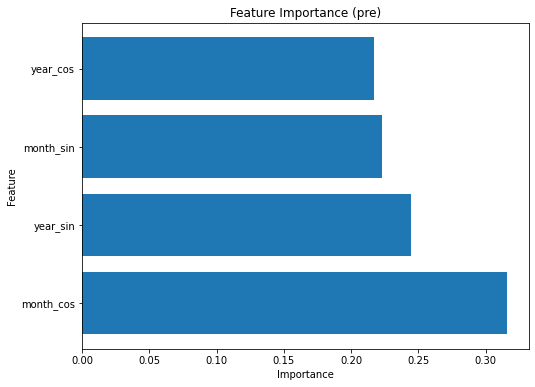

R^2 score on test set (beginning):  -2.3007682175755533
MSE on test set (beginning):  0.14492262832812144
     Feature  Importance
0   year_sin    0.301824
1   year_cos    0.286981
2  month_cos    0.282249
3  month_sin    0.128947


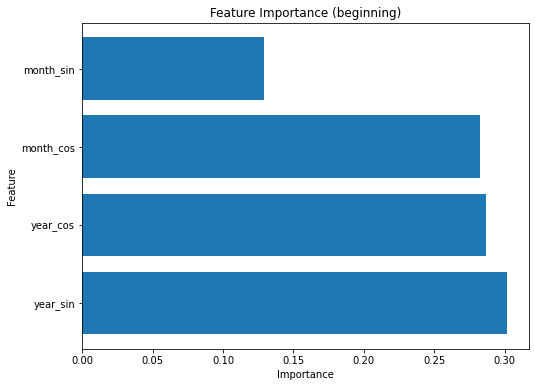

R^2 score on test set (middle):  0.12718883241214307
MSE on test set (middle):  0.0025434556694323646
     Feature  Importance
0   year_cos    0.315062
1  month_cos    0.263579
2   year_sin    0.239101
3  month_sin    0.182258


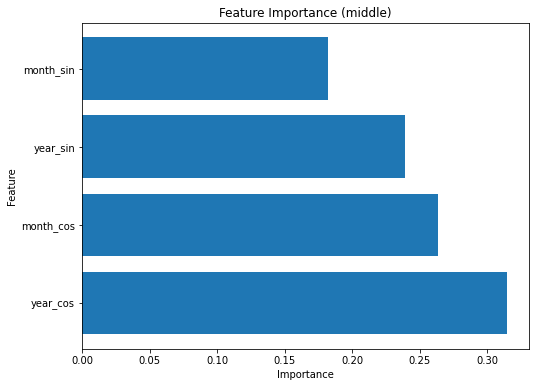

R^2 score on test set (end):  -0.6261613798997852
MSE on test set (end):  0.0009820312996000845
     Feature  Importance
0   year_cos    0.366184
1   year_sin    0.324726
2  month_cos    0.170871
3  month_sin    0.138220


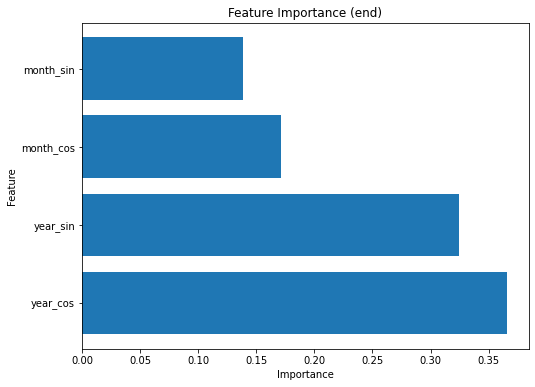

In [51]:
### This bit for delta
for category in ['pre', 'beginning', 'middle', 'end']:
    indices = eval(f"indices_{category}")  # Get the indices for the current category

    # Find common indexes
    X_Train_valid_indices = indices.intersection(X_delta_train.index)
    y_Train_valid_indices = indices.intersection(y_delta_train.index)
    X_Test_valid_indices = indices.intersection(X_delta_test.index)
    y_Test_valid_indices = indices.intersection(y_delta_test.index)

    # filter out by indeces
    X_train_category = X_delta_train.loc[X_Train_valid_indices]
    y_train_category = y_delta_train.loc[y_Train_valid_indices]
    X_test_category = X_delta_test.loc[X_Test_valid_indices]
    y_test_category = y_delta_test.loc[y_Test_valid_indices]

    # Apply XGB on all periods  
    model_delta.fit(X_train_category, y_train_category)  # Fit a new model on each subset
    y_pred_category = model_delta.predict(X_test_category)

    r2 = r2_score(y_test_category, y_pred_category)
    mse = mean_squared_error(y_test_category, y_pred_category)
    print(f"R^2 score on test set ({category}): ", r2)
    print(f"MSE on test set ({category}): ", mse)

    # Get the feature importance scores and plot them
    feature_importance = pd.DataFrame({'Feature': X_delta_train.columns, 'Importance': model_delta.feature_importances_})
    feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)
    print(feature_importance)

    # Plot the feature importance scores
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Feature Importance ({category})')
    plt.show()


R^2 score on test set (pre):  0.9996811334563557
MSE on test set (pre):  0.03400361527678678
     Feature  Importance
0   year_sin    0.675166
1   year_cos    0.323207
2  month_sin    0.001290
3  month_cos    0.000337


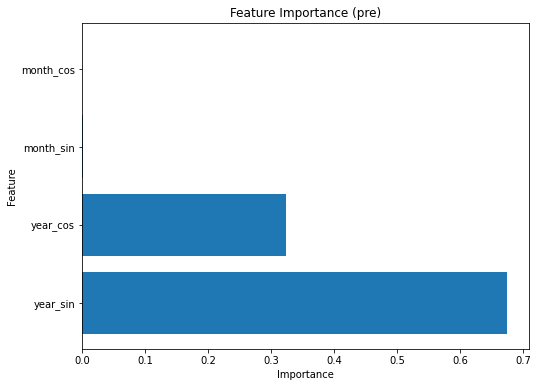

R^2 score on test set (beginning):  0.9987478195591643
MSE on test set (beginning):  0.1527435620585594
     Feature  Importance
0   year_sin    0.586924
1   year_cos    0.406912
2  month_cos    0.005232
3  month_sin    0.000933


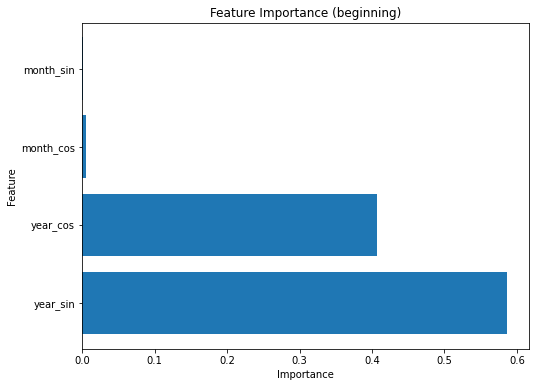

R^2 score on test set (middle):  0.9990428230783367
MSE on test set (middle):  0.11970559081506041
     Feature  Importance
0   year_sin    0.625415
1   year_cos    0.367746
2  month_sin    0.004708
3  month_cos    0.002131


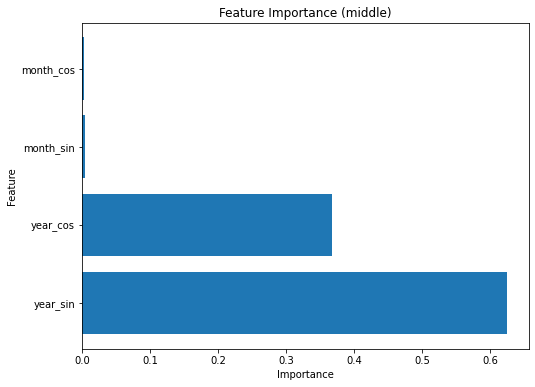

R^2 score on test set (end):  0.9999815599319191
MSE on test set (end):  0.0019153381948646662
     Feature  Importance
0   year_sin    0.566845
1   year_cos    0.425087
2  month_sin    0.007855
3  month_cos    0.000213


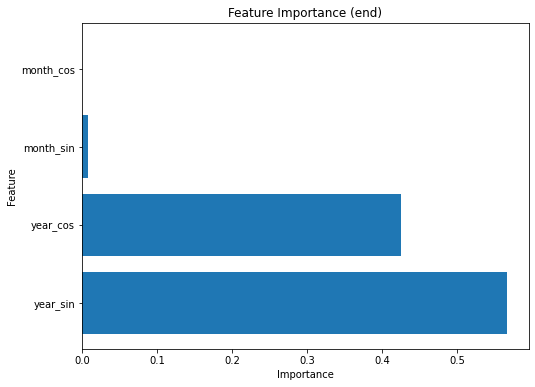

In [52]:
### This bit for absolute
for category in ['pre', 'beginning', 'middle', 'end']:
    indices = eval(f"indices_{category}")  # Get the indices for the current category

    # Find common indexes
    X_Train_valid_indices = indices.intersection(X_absolute_train.index)
    y_Train_valid_indices = indices.intersection(y_absolute_train.index)
    X_Test_valid_indices = indices.intersection(X_absolute_test.index)
    y_Test_valid_indices = indices.intersection(y_absolute_test.index)

    # filter out by indeces
    X_train_category = X_absolute_train.loc[X_Train_valid_indices]
    y_train_category = y_absolute_train.loc[y_Train_valid_indices]
    X_test_category = X_absolute_test.loc[X_Test_valid_indices]
    y_test_category = y_absolute_test.loc[y_Test_valid_indices]

    # Apply XGB on all periods  
    model_absolute.fit(X_train_category, y_train_category)  # Fit a new model on each subset
    y_pred_category = model_absolute.predict(X_test_category)

    r2 = r2_score(y_test_category, y_pred_category)
    mse = mean_squared_error(y_test_category, y_pred_category)
    print(f"R^2 score on test set ({category}): ", r2)
    print(f"MSE on test set ({category}): ", mse)

    # Get the feature importance scores and plot them
    feature_importance = pd.DataFrame({'Feature': X_absolute_train.columns, 'Importance': model_absolute.feature_importances_})
    feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)
    print(feature_importance)

    # Plot the feature importance scores
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Feature Importance ({category})')
    plt.show()


## LSTM

In [313]:
# This bit to find best LSTM model for when Ablation == True and for both target variables

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

for i in ["delta","absolute"]:
    
    indices = eval(f"indices_ablation")  # Get the indices for the current category

    # Find common indexes
    X_Train_valid_indices = indices.intersection(eval(f"X_{i}_train").index)
    y_Train_valid_indices = indices.intersection(eval(f"y_{i}_train").index)
    X_Test_valid_indices = indices.intersection(eval(f"X_{i}_test").index)
    y_Test_valid_indices = indices.intersection(eval(f"y_{i}_test").index)

    # filter out by indeces
    X_train_category = eval(f"X_{i}_train").loc[X_Train_valid_indices]  
    y_train_category = eval(f"y_{i}_train").loc[y_Train_valid_indices] 
    X_test_category = eval(f"X_{i}_test").loc[X_Test_valid_indices]  
    y_test_category = eval(f"y_{i}_test").loc[y_Test_valid_indices]
    
    # Impute missing values
    X_train_category = X_train_category.fillna(X_train_category.mean())
    y_train_category = y_train_category.fillna(y_train_category.mean())
    X_test_category = X_test_category.fillna(X_test_category.mean())

    
    # Reshape the input data to 3D array
    X_train_category = X_train_category.values.reshape((X_train_category.shape[0], 1, X_train_category.shape[1]))
    X_test_category = X_test_category.values.reshape((X_test_category.shape[0], 1, X_test_category.shape[1]))
    
    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(64, input_shape=(1, X_train_category.shape[2])))
    model.add(Dense(1))
    
    # Compile the model
    model.compile(loss='mse', optimizer='adam')
    
    # Fit the model to the training data
    model.fit(X_train_category, y_train_category, epochs=50, batch_size=64, validation_data=(X_test_category, y_test_category), verbose=0)
    
    # Evaluate the model on the test set
    y_pred_category = model.predict(X_test_category)
    r2 = r2_score(y_test_category, y_pred_category)
    mse = mean_squared_error(y_test_category, y_pred_category)
    print(f"R^2 score on test set ({i}): ", r2)
    print(f"MSE on test set ({i}): ", mse)


R^2 score on test set (delta):  -0.10340557736615308
MSE on test set (delta):  0.0038937158256251167
R^2 score on test set (absolute):  0.013685247670754519
MSE on test set (absolute):  157.86584193346172


--------